Week 3: Global Optimization

4.1 Monte Carlo optimization, 1D: In exercises 8-10, you used Metropolis Monte Carlo sampling to assemble position samples, {x_i} reflecting the probability distribution, P(x), associated with various potentials at given temperatures. In this exercise, we shall use the same technique, but the goal is not to establish a sample, {x_i}, but rather to identify the position, x_opt, where the potential has its global minimum value.

4.2 The potential

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
plt.rc('animation', html='jshtml') #something to do with with jupyter notebooks animation

In [3]:
#N = 50  # number of points
highlighted_dots = 5
Delta = 1  # magnitude of step size
steps = 100  # number of iterations in walk
kT = 1.0  # Temperature for the Metropolis criterion

In [4]:
#defining the potential
def V(x):
    return (-1  -np.exp(-((x+15)/10)**2) \
              -2*np.exp(-((x-10)/10)**2) + \
                -np.exp(-((x-35)/10)**2) \
              -3*np.exp(-((x-60)/10)**2) \
                -np.exp(-((x-85)/10)**2)\
              -2*np.exp(-((x-110)/10)**2) \
              ) * \
            (1+1/5*np.cos(2*np.pi/2.5*x))

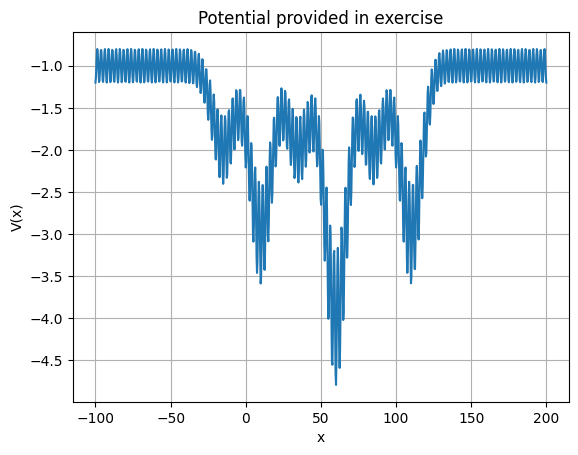

In [5]:
#plotting the potential
def plot_potential():
    x = np.linspace (-100,200,1000)
    y = V(x)

    plt.plot(x,y, label='V(x)')
    plt.title('Potential provided in exercise')
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.legend
    plt.grid(True)
    plt.show

plot_potential()

4.3 Short trajectories: Use the Metropolis Monte Carlo method to create a Markov chain trajectory at two different temperatures. The two figures to the left, depict the first 9 states of a low-temperature trajectory. The two figures to the right depict the trajectory at a higher temperature. The two upper plots show the sampled points as a function of how many steps have been taken, the "Monte Carlo time". The two lower plots show the sampled point in the energy landscape. Make similar plots and verify thereby that your implementation behaves qualitatively correct.

In [6]:
#metropolis sampling function specifically for the given potential in the exercise
def metropolis_sampling(x0, N, Delta,kT):
    samples = []
    current_x = x0
    lowest_V = 100000
    for _ in range(N):
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn
        
        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob and proposed_x<110 and proposed_x>-10:
            current_x = proposed_x  # Accept the move

        # Store the current position
        samples.append(current_x)
        if V(current_x)<lowest_V:
            lowest_V = V(current_x)

    return np.array(samples),lowest_V


In [7]:
output_of_met_samp = metropolis_sampling(3,5,1.5,0.010)
print(output_of_met_samp)

(array([3.        , 3.        , 3.        , 3.        , 4.76595622]), np.float64(-2.9637250230911683))


In [8]:
#setting up the two chains

MC_time_interval = 9
delta = 1.5
starting_x = 3

# First chain
kT_1 = 0.010
chain_1 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_1)
lowest_chain1 = chain_1[1]
chain_1 = chain_1[0]
chain_1 = np.insert(chain_1, 0, starting_x)
MC_steps_1 = np.arange(MC_time_interval + 1)
#lowest_chain1 = 

# Second chain
kT_2 = 100.0
chain_2 = metropolis_sampling(starting_x, MC_time_interval, delta, kT_2)
lowest_chain2 = chain_2[1]
chain_2 = chain_2[0]
chain_2 = np.insert(chain_2, 0, starting_x)
MC_steps_2 = np.arange(MC_time_interval + 1)

print(lowest_chain1,lowest_chain2)

-3.0959316115556756 -3.581887953856044


Comment on above output: we might expect that the high temp trajectory always finds the lowest pot, but that is not always the case if we are unlucky that the high temp trajectory goes mostly upwards in pot. This will be alleviated by a longer chain!

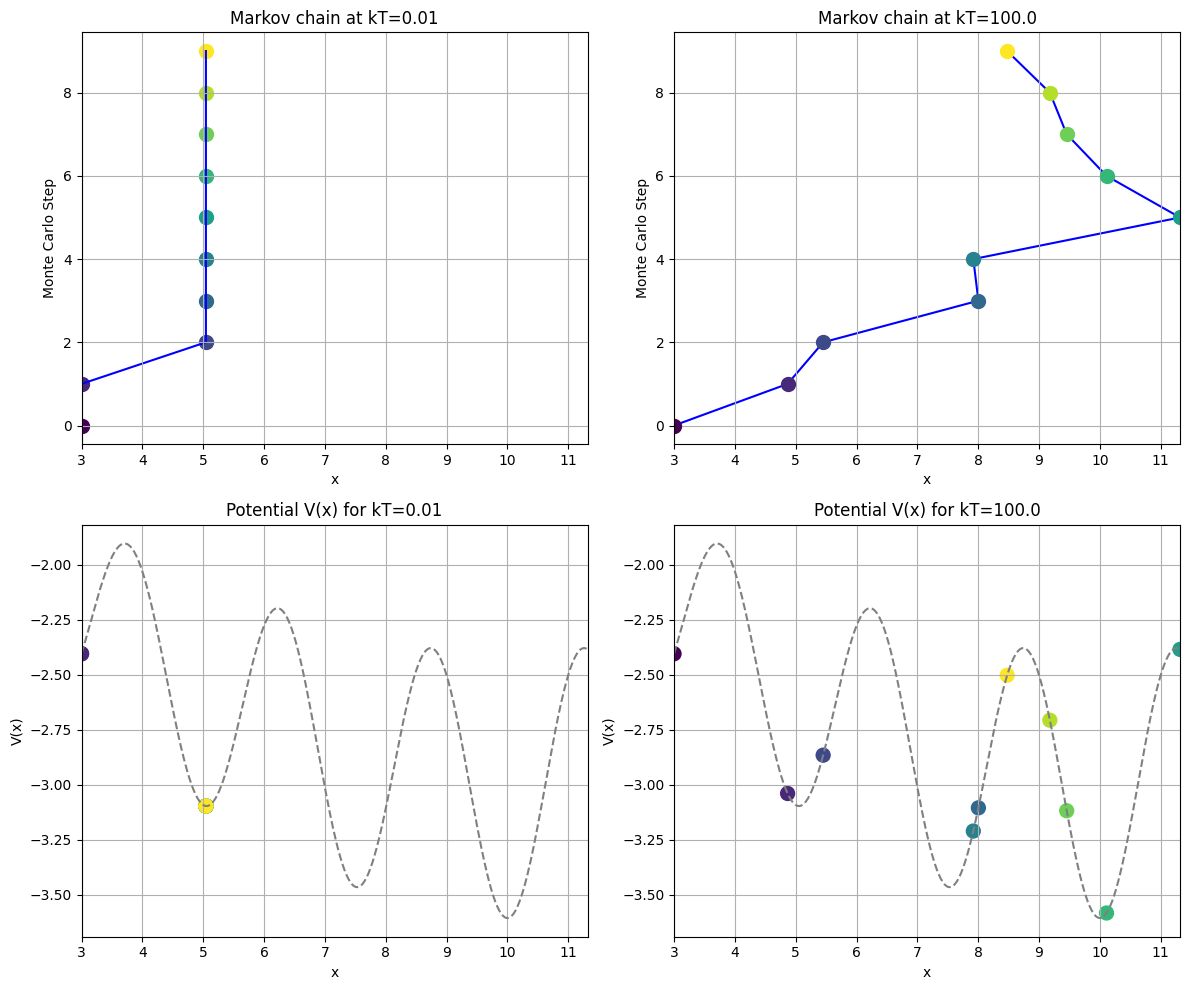

In [9]:
#actually making the 4 plots

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

x_limits = (min(min(chain_1),min(chain_2)), max(max(chain_1),max(chain_2)))
x_range = np.linspace(x_limits[0], x_limits[1], 500)
V_values = V(x_range)

#first plot 
colors_1 = plt.cm.viridis(np.linspace(0, 1, len(chain_1)))
for i in range(len(chain_1)):
    axs[0, 0].scatter(chain_1[i], MC_steps_1[i], color=colors_1[i], s=100, zorder=1)  # Larger points
axs[0, 0].plot(chain_1, MC_steps_1, linestyle='-', color='b', zorder=1)
axs[0, 0].set_title(f'Markov chain at kT={kT_1}')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('Monte Carlo Step')
axs[0, 0].set_xlim(x_limits)
axs[0, 0].grid(True)

#second plot
colors_2 = plt.cm.viridis(np.linspace(0, 1, len(chain_2)))
for i in range(len(chain_2)):
    axs[0, 1].scatter(chain_2[i], MC_steps_2[i], color=colors_2[i], s=100, zorder=2)  # Larger points
axs[0, 1].plot(chain_2, MC_steps_2, linestyle='-', color='b', zorder=1)
axs[0, 1].set_title(f'Markov chain at kT={kT_2}')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('Monte Carlo Step')
axs[0, 1].set_xlim(x_limits)
axs[0, 1].grid(True)

# Plot the potential energy for the first chain in the bottom left
axs[1, 0].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 0].scatter(chain_1, V(chain_1), color=colors_1, s=100)  # Superimpose chain_1 points with corresponding colors
axs[1, 0].set_title(f'Potential V(x) for kT={kT_1}')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('V(x)')
axs[1, 0].set_xlim(x_limits)
axs[1, 0].grid(True)

# Plot the potential energy for the second chain in the bottom right
axs[1, 1].plot(x_range, V_values, color='gray', linestyle='--', label='Potential V(x)')
axs[1, 1].scatter(chain_2, V(chain_2), color=colors_2, s=100)  # Superimpose chain_2 points with corresponding colors
axs[1, 1].set_title(f'Potential V(x) for kT={kT_2}')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('V(x)')
axs[1, 1].set_xlim(x_limits)
axs[1, 1].grid(True)


plt.tight_layout()
plt.show()

4.4 Long trajectories:

c) Start one or several low-temperature walkers and observe that they might get stuck in local minima.
d) Start one or several high-temperature walkers and observe that they are less prone to get stuck in local minima, and that more of them eventually spend some time near the global minimum.

I have combined them in one animation. There is one "walker" that is low temp, and one that is high temp.

In [10]:
def animate_metropolis_sampling(MC_time_interval, delta, kT_list, starting_x_list):
        
    # Ensure kT_list and starting_x_list are the same length
    assert len(kT_list) == len(starting_x_list), "kT_list and starting_x_list must have the same length"

    # Get the chain of x-values and corresponding y-values (V(x)) for each starting x
    chains = []
    for kT, starting_x in zip(kT_list, starting_x_list):
        chain = metropolis_sampling(starting_x, MC_time_interval, delta, kT)
        chain = np.insert(chain, 0, starting_x)
        chains.append((chain, V(chain)))
    
    # Combine x and y into points_in_time for each chain
    points_in_time = [list(zip(xs, ys)) for xs, ys in chains]

    # Create figure for animation
    fig, ax = plt.subplots()

    # Plot the static potential V(x)
    x_static = np.linspace(0, 100, 1000)
    y_static = V(x_static)
    ax.plot(x_static, y_static, label="V(x)", color='blue')

    # Set limits based on the data
    ax.set_xlim(min(x_static), max(x_static))
    ax.set_ylim(min(y_static), max(y_static))
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")

    scat = ax.scatter([], [], marker='o', color='red')

    # Update function for the animation
    def update(frame):
        data = np.array([points[frame] for points in points_in_time])  # Collect points for all chains
        scat.set_offsets(data)
        return [scat]

    # Create the animation
    anim = FuncAnimation(fig, update, frames=MC_time_interval+1, interval=100, blit=True)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# Example usage:
animate_metropolis_sampling(100, 1, [0.1, 1000], [30, 70])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

4.5 Success Statistics: Formalize the observation of the efficiency of the Metropolis Monte Carlo method for global optimization.

In [ ]:
#metropolis sampling function specifically for the given potential in the exercise
def metropolis_sampling_v2(x0, Delta,kT):
    iterations = 0
    current_x = x0
    x = current_x
    while (V(x)>-4.5):
        if iterations>10000:
            break
        # if iterations%10000==0:
        #     print(f"Progress in steps: {iterations}")
        # Propose new x' using random walk: x' = x + delta * N(0,1)
        RNDn = np.random.randn()  # Random distribution "randn"
        proposed_x = current_x + Delta * RNDn

        # Calculate potential energy at current and proposed positions
        current_pot = V(current_x)
        proposed_pot = V(proposed_x)

        # Acceptance probability (min(1, exp(-(V(x') - V(x)) / kT)))
        delta_E = proposed_pot - current_pot
        acceptance_prob = min(1, np.exp(-delta_E / kT)) # RND<exp(-Delta_E/kT)

        # Accept or reject the new position
        if np.random.rand() < acceptance_prob and (proposed_x<110 or proposed_x>-10):
            current_x = proposed_x  # Accept the move
        x = current_x
        iterations += 1
        if (current_x>110 or current_x<-10):
            print(f"now x is {current_x}")
        
    return current_x, iterations

low_x, iterations = metropolis_sampling_v2(70,0.1,1.0)
print("x",low_x)
print("V",V(low_x))
print("steps",iterations)

x 62.59588113708713
V -4.551897912176023
steps 1786


In [ ]:
kBTs = [0.004,0.02,0.1,0.5,2.5]
for kBT in kBTs:
    _ , steps = metropolis_sampling_v2(70,0.1,kBT)

Progress in steps: 0
Progress in steps: 10000
Progress in steps: 20000
Progress in steps: 30000
Progress in steps: 40000
Progress in steps: 50000
Progress in steps: 60000
Progress in steps: 70000
Progress in steps: 80000
Progress in steps: 90000
Progress in steps: 100000
Progress in steps: 110000
Progress in steps: 120000
Progress in steps: 130000
Progress in steps: 140000
Progress in steps: 150000
Progress in steps: 160000
Progress in steps: 170000
Progress in steps: 180000
Progress in steps: 190000
Progress in steps: 200000
Progress in steps: 210000
Progress in steps: 220000
Progress in steps: 230000
Progress in steps: 240000
Progress in steps: 250000
Progress in steps: 260000
Progress in steps: 270000
Progress in steps: 280000
Progress in steps: 290000
Progress in steps: 300000
Progress in steps: 310000
Progress in steps: 320000
Progress in steps: 330000
Progress in steps: 340000
Progress in steps: 350000
Progress in steps: 360000
Progress in steps: 370000
Progress in steps: 380000


KeyboardInterrupt: 

I'm going to run the above code many times and record how many steps it takes to come close to the global minimum. Then I'll plot the result first as a function of steps. Then plot the cumulative success rate (percentage as a function of steps).

In [ ]:
big_list_of_step_counts = []
for i in range(200):
    metro_sample = metropolis_sampling_v2(50,0.1,2.5)
    steps = metro_sample[1]
    big_list_of_step_counts.append(steps)
    
    if (i%10==0):
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [ ]:
print(big_list_of_step_counts)

[3549, 10000, 5363, 1884, 1584, 4158, 10000, 10000, 2452, 10000, 2020, 1002, 4961, 2479, 9485, 3228, 10000, 7098, 3507, 10000, 4575, 10000, 10000, 1934, 10000, 10000, 10000, 604, 3322, 7066, 3677, 6034, 10000, 10000, 2374, 2792, 10000, 2397, 10000, 2906, 3344, 3002, 10000, 7743, 1722, 5644, 3612, 2712, 10000, 9855, 10000, 10000, 10000, 5915, 8209, 10000, 4163, 2909, 4170, 5904, 3859, 10000, 2891, 1749, 10000, 4618, 2526, 8233, 7389, 1658, 10000, 5152, 2336, 7803, 1773, 2188, 3863, 2837, 1970, 10000, 1883, 10000, 10000, 10000, 10000, 3637, 1744, 10000, 1578, 10000, 10000, 10000, 2972, 2400, 3303, 10000, 10000, 10000, 1587, 8099, 2192, 10000, 10000, 6057, 1426, 10000, 10000, 7221, 3353, 10000, 10000, 6116, 10000, 8600, 10000, 7392, 1756, 10000, 1915, 10000, 10000, 3330, 10000, 5882, 10000, 9226, 2251, 5291, 3509, 1994, 10000, 3127, 10000, 10000, 10000, 2112, 2496, 1115, 3341, 2169, 2915, 3170, 10000, 2512, 978, 6463, 10000, 6083, 6539, 10000, 10000, 8065, 7785, 6222, 10000, 7343, 1827, 6

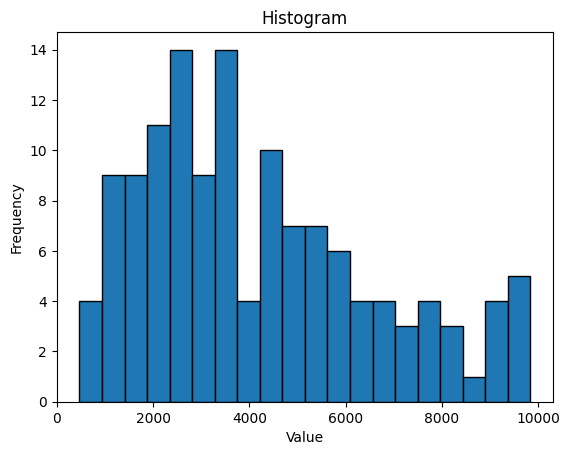

Bin edges: [ 467.   935.8 1404.6 1873.4 2342.2 2811.  3279.8 3748.6 4217.4 4686.2
 5155.  5623.8 6092.6 6561.4 7030.2 7499.  7967.8 8436.6 8905.4 9374.2
 9843. ]
Counts: [ 4  9  9 11 14  9 14  4 10  7  7  6  4  4  3  4  3  1  4  5]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example list of 1000 numbers
data = big_list_of_step_counts
data = [steps for steps in data if steps <= 10000]


# Define the number of bins (you can adjust the number as needed)
num_bins = 20

# Create the histogram
counts, bin_edges = np.histogram(data, bins=num_bins)

# Plot the histogram
plt.hist(data, bins=num_bins, edgecolor='black')
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Optional: Print the histogram data
print("Bin edges:", bin_edges)
print("Counts:", counts)


Exercise 12

5.1 MC optimization, 2D: In this exercise, we shall use global optimization based on the Metropolis Monte Carlo method to optimize the position of an atom in a two dimensional space, where two other atoms are placed.

The atoms interact via the Lennard-Jones pair potential: [expression]

The total potential energy of the ensemble of Lennard-Jones atoms is: [expression]

5.2 Calculator class

In [15]:
from scipy.spatial.distance import pdist

class LennardJones:
    def __init__(self, eps0=5, sigma=2**(-1/6), r_min=0.89):
        self.eps0 = eps0
        self.sigma = sigma
        self.r_min = r_min
        
    def _V(self, r):
        r = np.maximum(r,self.r_min)
        return 4 * self.eps0 * ((self.sigma / r) ** 12 - (self.sigma / r) ** 6)

    def energy(self, pos):
        distances = pdist(pos)  
        return np.sum(self._V(distances))

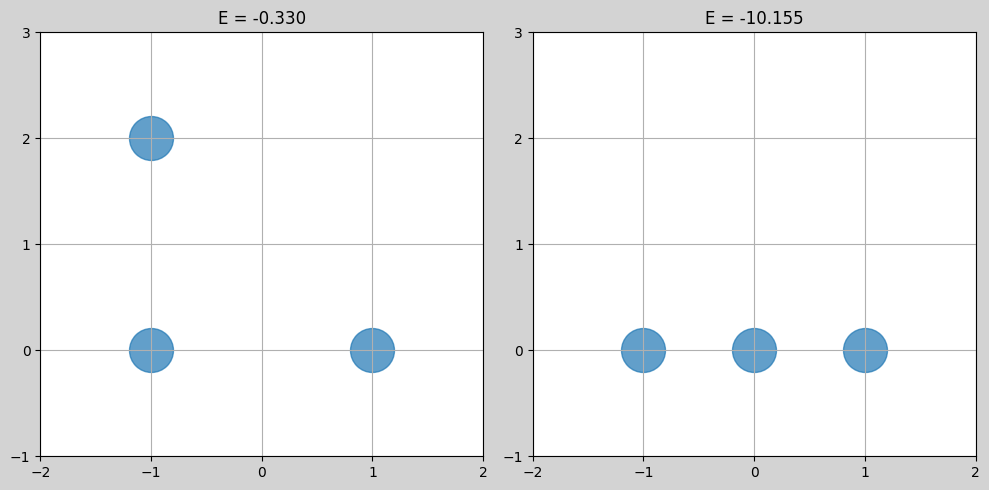

In [16]:
# plotting function for the simple setup
def plot_atoms(ax, pos, E, color):
    ax.scatter(pos[:,0], pos[:,1],s=1000, alpha=0.7)
    ax.set_xlim([-2,2])
    ax.set_ylim([-1,3])
    ax.set_xticks(np.arange(-2,3,1))
    ax.set_yticks(np.arange(-1,4,1))
    ax.grid(True)
    ax.set_title(f"E = {E:.3f}")

fig, axes = plt.subplots(1,2,figsize=(10,5))
fig.patch.set_facecolor('lightgrey')

pos1 = np.array([[-1, 2], [-1, 0], [1, 0]])
pos2 = np.array([[-1, 0], [0, 0], [1, 0]])

lj = LennardJones()
E1 = lj.energy(pos1)
E2 = lj.energy(pos2)

plot_atoms(axes[0],pos1,E1,color='orange')
plot_atoms(axes[1], pos2, E2, color='blue')

plt.tight_layout()
plt.show()

In [ ]:
#testing the LennardJones class with different setups

lj = LennardJones()
pos = np.array([[100, 2], [-220, 4], [3, -100]])
print(lj.energy(pos))
pos = np.array([[-1, 0], [0, 0], [1, 0]])
print(lj.energy(pos))
pos = np.array([[-1, 0], [-1.5, 1.5], [1, 0]])
print(lj.energy(pos))

-1.340097964416143e-12
-10.155029296875
-0.7908193694742746


5.3 Energy landscape: Assume that two atoms are static and the third atom can move. Plot the total pot energy of this 3-atomic cluster as a fct of x- and y-coordinates of the third atom.

C:\Users\jacob\AppData\Local\Temp\ipykernel_13104\3579300496.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[k].legend()


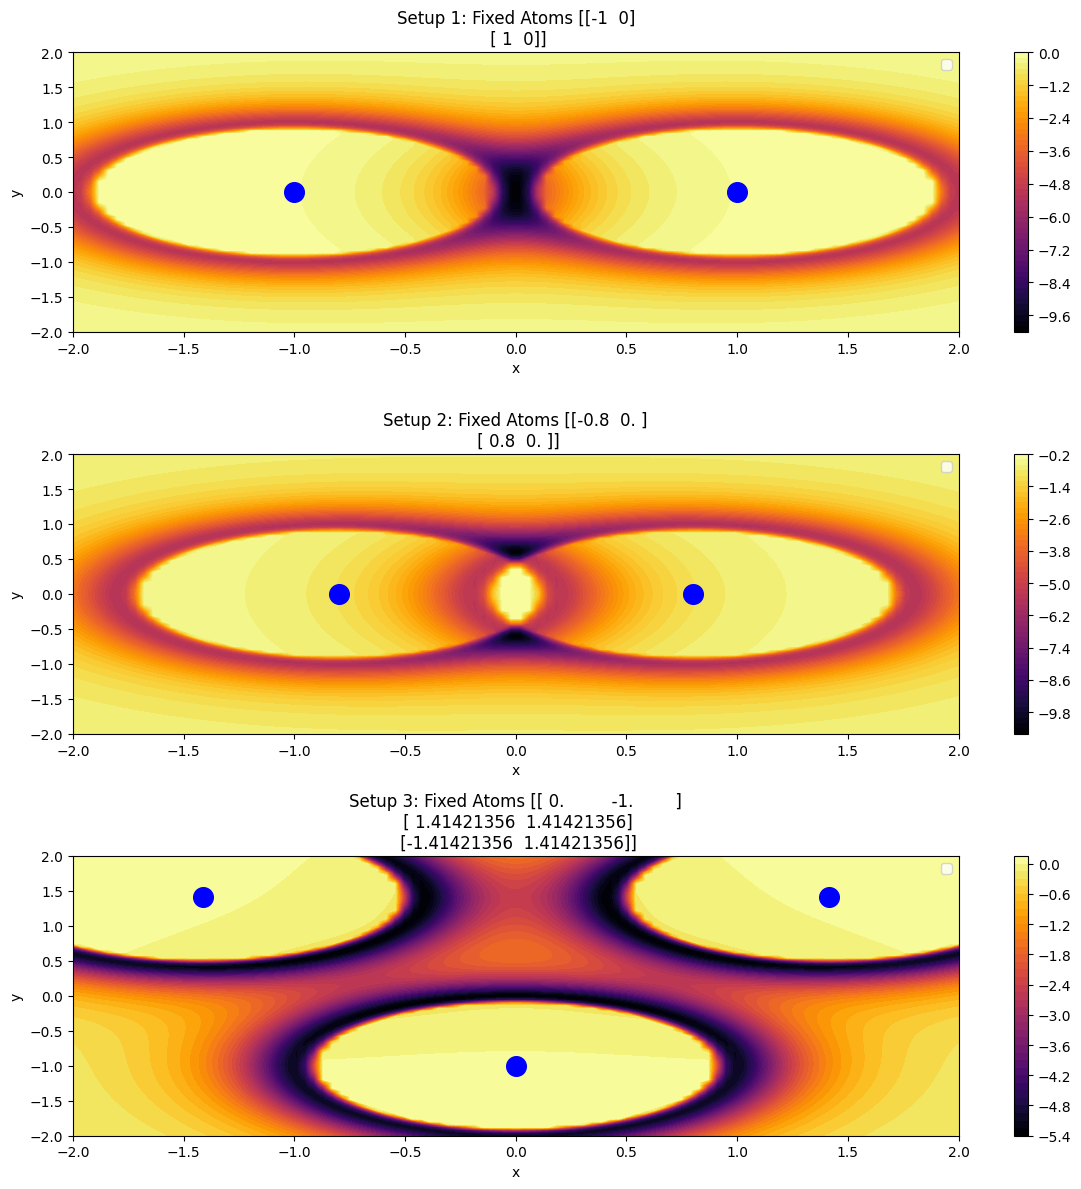

In [ ]:
lj = LennardJones()

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

fixed_atoms1 = np.array([[-1, 0], [1, 0]])
fixed_atoms2 = np.array([[-0.8, 0], [0.8, 0]])
fixed_atoms3 = np.array([[0,-1],[np.sqrt(2),np.sqrt(2)],[-np.sqrt(2),np.sqrt(2)]])
fixed_setup = []
fixed_setup.append(fixed_atoms1)
fixed_setup.append(fixed_atoms2)
fixed_setup.append(fixed_atoms3)
for k in range(len(fixed_setup)):
    for i in range(len(x)):
        for j in range(len(y)):
            third_atom = np.array([[X[i, j], Y[i, j]]])  # Third atom's position
            pos = np.vstack((fixed_setup[k], third_atom))  # Combine fixed and third atom
            Z[i, j] = lj.energy(pos)  # Compute the total energy for this configuration

    contour = axes[k].contourf(X, Y, Z, levels=50, cmap='inferno')  # Filled contours
    fig.colorbar(contour, ax=axes[k])  # Add color scale to each subplot
    axes[k].scatter(fixed_setup[k][:, 0], fixed_setup[k][:, 1], color='blue', s=200)
    axes[k].set_title(f"Setup {k+1}: Fixed Atoms {fixed_setup[k]}")
    axes[k].set_xlabel("x")
    axes[k].set_ylabel("y")
    axes[k].legend()

plt.tight_layout()
plt.show()

5.4 Metropolis MC optimization: metropolis MC optimization at low temp for one of the atoms.

In [138]:
class MetropolisMonteCarlo:
    def __init__(self, potential, fixed_atoms=None, movable_atoms=None, Delta=0.1, kT=0.2, N=10000):
        """
        Initialize the Metropolis Monte Carlo simulation.

        Args:
            potential: A potential object (e.g., LennardJones) with an `energy` method.
            fixed_atoms: Fixed atom positions as a (n, 2) array.
            movable_atoms: Initial positions of movable atoms as a (m, 2) array.
            Delta: Step size for random moves.
            kT: Temperature parameter.
            N: Number of Monte Carlo iterations.
        """
        self.potential = potential
        self.fixed_atoms = np.array(fixed_atoms) if fixed_atoms is not None else np.empty((0, 2))
        self.movable_atoms = np.array(movable_atoms).reshape(-1, 2)  # Ensure 2D array
        self.Delta = Delta
        self.kT = kT
        self.N = N
        self.samples = []
        self.energies = []

    def run(self):
        """Run the Metropolis Monte Carlo simulation."""
        current_pos = self.movable_atoms.copy()  # Ensure 2D array

        for _ in range(self.N):
            # Propose new positions for the movable atoms
            proposed_pos = current_pos + self.Delta * np.random.randn(*current_pos.shape)

            # Combine fixed atoms with movable atoms for energy calculations
            full_current_pos = np.vstack((self.fixed_atoms, current_pos))
            full_proposed_pos = np.vstack((self.fixed_atoms, proposed_pos))

            # Check for minimum distance constraint
            min_distance = np.min(pdist(full_proposed_pos))
            if min_distance < self.potential.r_min:
                continue  # Reject the proposal if atoms are too close

            # Calculate potential energies
            current_energy = self.potential.energy(full_current_pos)
            proposed_energy = self.potential.energy(full_proposed_pos)

            # Acceptance probability
            delta_E = proposed_energy - current_energy
            acceptance_prob = min(1, np.exp(-delta_E / self.kT))

            # Accept or reject the new configuration
            if np.random.rand() < acceptance_prob:
                current_pos = proposed_pos.copy()  # Accept the move

            # Store the current configuration and energy
            self.samples.append(current_pos.copy().reshape(-1, 2))  # Store as 2D array
            self.energies.append(current_energy)

        self.samples = np.array(self.samples)
        self.energies = np.array(self.energies)

    def get_results(self):
        """Get the final positions and energies."""
        return self.samples, self.energies


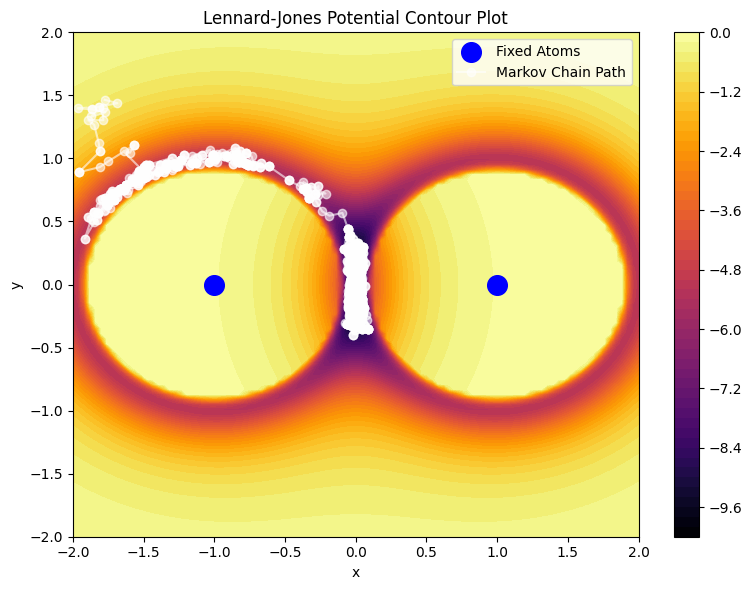

In [139]:
# Parameters
N = 10000
Delta = 0.1
kT = 0.2
lj = LennardJones()

# Fixed atoms at (-1, 0) and (1, 0)
fixed_atoms = [[-1, 0], [1, 0]]

# Initial position for the movable atom (ensure it's a 2D array)
x0y0 = np.array([[-1.5, 1.5]])

# Initialize Metropolis Monte Carlo simulation
mc = MetropolisMonteCarlo(
    potential=lj,
    fixed_atoms=fixed_atoms,
    movable_atoms=x0y0,
    Delta=Delta,
    kT=kT,
    N=N
)

# Run the simulation
mc.run()

# Retrieve results
samples, energies = mc.get_results()

# Generate the Lennard-Jones potential contour plot
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

fixed_atoms_array = np.array(fixed_atoms)

for i in range(len(x)):
    for j in range(len(y)):
        third_atom = np.array([[X[i, j], Y[i, j]]])  # Third atom position
        pos = np.vstack((fixed_atoms_array, third_atom))  # Combine fixed and third atom positions
        Z[i, j] = lj.energy(pos)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='inferno')  # Filled contours
plt.colorbar(contour)

# Plot positions of the fixed atoms
plt.scatter(fixed_atoms_array[:, 0], fixed_atoms_array[:, 1], color='blue', s=200, label="Fixed Atoms")

# Plot Markov chain - sample positions
samples = samples.reshape(-1, 2)  # Ensure samples are 2D for indexing
plt.plot(samples[:, 0], samples[:, 1], 'o-', color='white', alpha=0.6, label="Markov Chain Path")

# Add labels, title, and legend
plt.title("Lennard-Jones Potential Contour Plot")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()


Exercise 13

6.1 Monte Carlo optimization, high-D: In this exercise, we keep performing global optimization based on the Metropolis Monte Carlo method to optimize the atomic positions. This time, however, we do it for several atoms at the same time. Since they each contribute with two dimensions, we are effectively performing high-dimensional global optimization.

6.2 3-Atomic cluster: Perform Metropolis MC opt for a 3-atomic LJ cluster problem starting from a random initial config (possibly with 1 static atom at (0,0)).

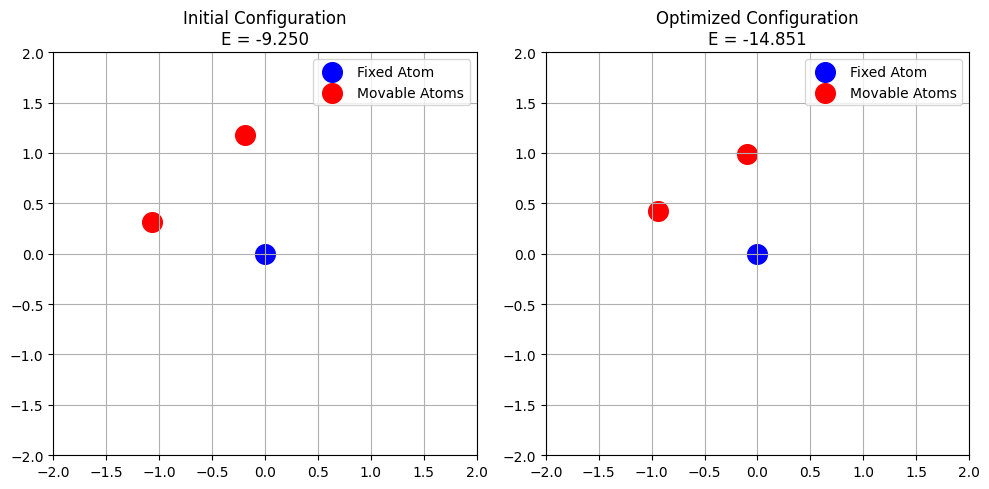

In [140]:
# Fixed atom at (0, 0)
fixed_atom = [[0, 0]]

# Initial positions for two movable atoms
random_atoms = np.random.uniform(-2, 2, size=(2, 2))

# Initialize Lennard-Jones potential
lj = LennardJones()

# Initialize Metropolis Monte Carlo simulation
mc = MetropolisMonteCarlo(
    potential=lj,
    fixed_atoms=fixed_atom,
    movable_atoms=random_atoms,
    Delta=0.1,
    kT=0.2,
    N=10000
)

# Run the simulation
mc.run()

# Get results
samples, energies = mc.get_results()
final_positions = np.vstack((fixed_atom, samples[-1]))

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Initial configuration
plt.subplot(1, 2, 1)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(random_atoms[:, 0], random_atoms[:, 1], color='red', s=200, label="Movable Atoms")
plt.title(f"Initial Configuration\nE = {lj.energy(np.vstack((fixed_atom, random_atoms))):.3f}")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.grid()

# Final configuration
plt.subplot(1, 2, 2)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(final_positions[1:, 0], final_positions[1:, 1], color="red", s=200, label="Movable Atoms")
plt.title(f"Optimized Configuration\nE = {lj.energy(final_positions):.3f}")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

6.3 6-atom cluster

An auxiliary function that makes sure that the initial random configuration is not too close.

In [141]:
def initialize_positions(fixed_atoms, num_movable, r_min, range_min=-2, range_max=2, max_attempts=1000):
    """
    Generate random initial positions for movable atoms with a minimum distance constraint.

    Args:
        fixed_atoms (array-like): Positions of fixed atoms, shape (n, 2).
        num_movable (int): Number of movable atoms to initialize.
        r_min (float): Minimum allowable distance between any two atoms.
        range_min (float): Minimum value for the random range.
        range_max (float): Maximum value for the random range.
        max_attempts (int): Maximum number of attempts to generate a valid configuration.

    Returns:
        np.ndarray: Random positions for the movable atoms, shape (num_movable, 2).
    """
    positions = []
    fixed_atoms = np.array(fixed_atoms)
    all_atoms = fixed_atoms.copy()  # Start with fixed atoms

    for _ in range(num_movable):
        for _ in range(max_attempts):
            # Generate a random position
            candidate = np.random.uniform(range_min, range_max, size=(1, 2))
            
            # Combine fixed and movable atoms for distance checks
            temp_atoms = np.vstack((all_atoms, candidate))
            
            # Check pairwise distances
            if np.min(pdist(temp_atoms)) >= r_min:
                positions.append(candidate[0])
                all_atoms = np.vstack((all_atoms, candidate))  # Add to all_atoms for subsequent checks
                break
        else:
            raise RuntimeError("Failed to generate a valid configuration within max_attempts.")
    
    return np.array(positions)


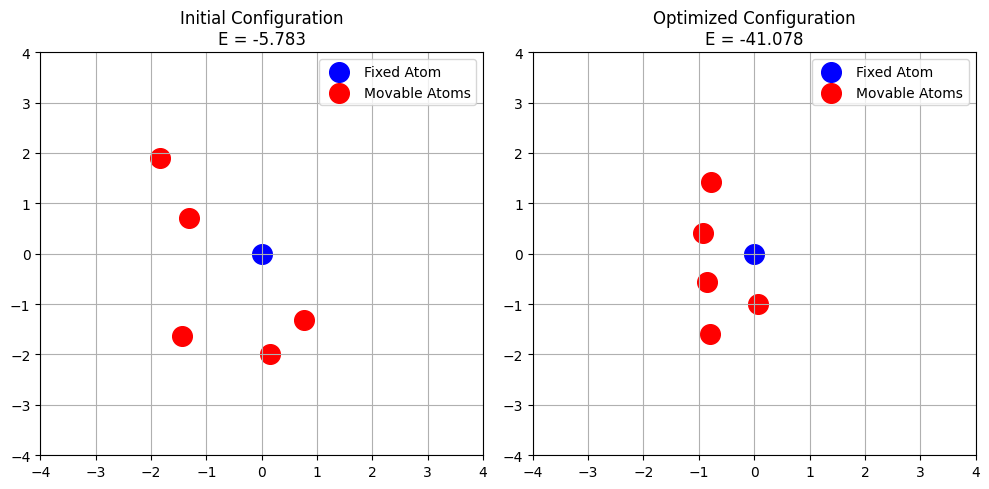

In [ ]:
# Fixed atom at (0, 0)
fixed_atom = [[0, 0]]

# Initial positions for two movable atoms
random_atoms = initialize_positions(fixed_atom, num_movable=5, r_min=lj.r_min) #enforcing a minimum distance on the initial config

# Initialize Lennard-Jones potential
lj = LennardJones()

# Initialize Metropolis Monte Carlo simulation
mc = MetropolisMonteCarlo(
    potential=lj,
    fixed_atoms=fixed_atom,
    movable_atoms=random_atoms,
    Delta=0.1,
    kT=0.2,
    N=50000
)

# Run the simulation
mc.run()

# Get results
samples, energies = mc.get_results()
final_positions = np.vstack((fixed_atom, samples[-1]))

plt.figure(figsize=(10, 5))

# Initial configuration
plt.subplot(1, 2, 1)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(random_atoms[:, 0], random_atoms[:, 1], color='red', s=200, label="Movable Atoms")
plt.title(f"Initial Configuration\nE = {lj.energy(np.vstack((fixed_atom, random_atoms))):.3f}")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()
plt.grid()

# Final configuration
plt.subplot(1, 2, 2)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(final_positions[1:, 0], final_positions[1:, 1], color="red", s=200, label="Movable Atoms")
plt.title(f"Optimized Configuration\nE = {lj.energy(final_positions):.3f}")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

6.4 7-atom cluster

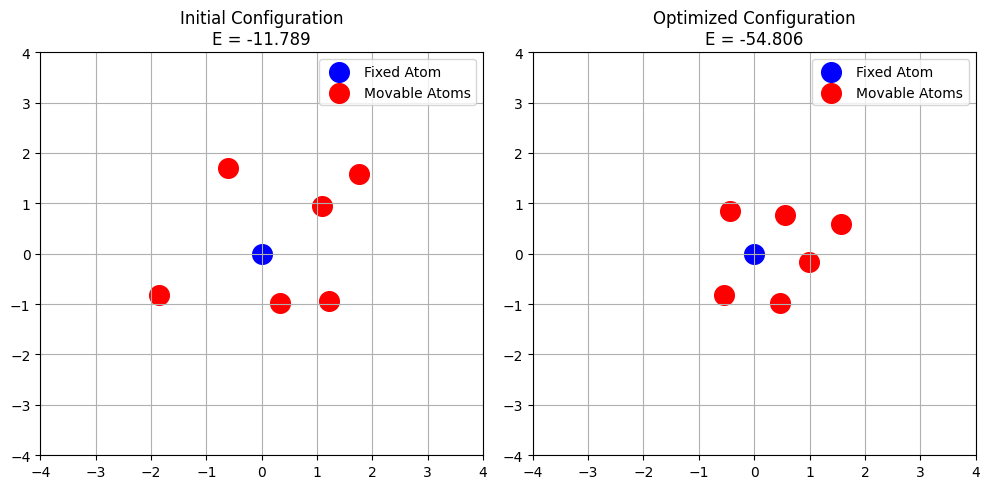

In [148]:
# Fixed atom at (0, 0)
fixed_atom = [[0, 0]]

# Initial positions for two movable atoms
random_atoms = initialize_positions(fixed_atom, num_movable=6, r_min=lj.r_min) #enforcing a minimum distance on the initial config

# Initialize Lennard-Jones potential
lj = LennardJones()

# Initialize Metropolis Monte Carlo simulation
mc = MetropolisMonteCarlo(
    potential=lj,
    fixed_atoms=fixed_atom,
    movable_atoms=random_atoms,
    Delta=0.1,
    kT=0.2,
    N=50000
)

# Run the simulation
mc.run()

# Get results
samples, energies = mc.get_results()
final_positions = np.vstack((fixed_atom, samples[-1]))

plt.figure(figsize=(10, 5))

# Initial configuration
plt.subplot(1, 2, 1)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(random_atoms[:, 0], random_atoms[:, 1], color='red', s=200, label="Movable Atoms")
plt.title(f"Initial Configuration\nE = {lj.energy(np.vstack((fixed_atom, random_atoms))):.3f}")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()
plt.grid()

# Final configuration
plt.subplot(1, 2, 2)
plt.scatter(fixed_atom[0][0], fixed_atom[0][1], color="blue", s=200, label="Fixed Atom")
plt.scatter(final_positions[1:, 0], final_positions[1:, 1], color="red", s=200, label="Movable Atoms")
plt.title(f"Optimized Configuration\nE = {lj.energy(final_positions):.3f}")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()